### A Binary Classifier built using a FC network, with PyTorch

We will be working with the Attrition dataset and we want to build a binary classifier: a model enabling to predict if the employee wants to leave the company (target = 1)

In this Notebook we show **how-to automatically find the best learning rate**

In [1]:
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

import pytorch_lightning as pl
# adding CSVLogger to the trainer we get at the end
# metrics.csv from which we can easily get a plot of loss vs epochs
from pytorch_lightning.loggers import CSVLogger

from attrition_dataset import AttritionDataset

# pyplot to plot the training loss
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

In [2]:
# check that access to GPU is OK
torch.cuda.is_available()

True

In [3]:
# need to make training reproducible
torch.manual_seed(42)

In [4]:
# globals

EPOCHS = 800

#### Here you find defined the Network architecture

In [5]:
# we need to implement a class subclassing nn.Module, writing the forward method

#non conviene avere una rete troppo profonda e con troppi parametri... i dati non sono tantissimi
class FirstFC(pl.LightningModule):
    # here we define the structure
    def __init__(self, learning_rate=1e-3):
        super(FirstFC, self).__init__()
        self.fc1 = nn.Linear(30, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 10)
        self.fc5 = nn.Linear(10, 1)
        # fondamentale memorizzare anche il dropout tra gli attributi 
        # per disattivarlo in modalità eval
        # altrimenti in eval i risultati non sono pienamente riproducibili
        self.drop = nn.Dropout(0.1)
        
        # to find the best LR
        self.learning_rate = learning_rate
    
    # here we implement the forward pass
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        # the last layer must give the prob that it is positive... so we use sigmoid
        # so we must use nn.BCELoss
        x = torch.sigmoid(self.fc5(x))
        
        return x
    
    def configure_optimizers(self):
        # qui possiamo anche pluggare un LR scheduler !!!
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        return optimizer
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        
        outputs = self.forward(inputs)
            
        # we need to add this !
        targets = targets.unsqueeze(1)
            
        loss = nn.BCELoss()(outputs, targets)
        
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        
        outputs = self.forward(inputs)
            
        # we need to add this !
        targets = targets.unsqueeze(1)
            
        loss = nn.BCELoss()(outputs, targets)
        
        self.log("validation_loss", loss, on_epoch=True, prog_bar=True)
        
        return loss

In [6]:
# dataset
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

attrition_ds = AttritionDataset(attrition_path, over_sample=True)

# split in train and validation
FRAC = 0.1
N_TRAIN = int(len(attrition_ds)*(1. - FRAC))
N_VALID = len(attrition_ds) - N_TRAIN

train_set, val_set = torch.utils.data.random_split(attrition_ds, [N_TRAIN, N_VALID], generator=torch.Generator().manual_seed(42))

print(f"We have {len(train_set)} samples in training set...")
print(f"We have {len(val_set)} samples in validation set...")

We have 2219 samples in training set...
We have 247 samples in validation set...


In [7]:
# oversampling the size has greatly increased performance

In [8]:
# dataloaders

# aumentando il btch size le prestazioni peggiorano
BATCH_SIZE = 64

train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

#### Do the test to find the best LR (in a given interval)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datascience/conda/pytorch_onoci_v1_0/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/datascience/conda/pytorch_onoci_v1_0/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/datascience/pytorch-on-oci/ch-04/.lr_find_65e5189f-2545-4050-a6be-b909df0df62c.ckpt


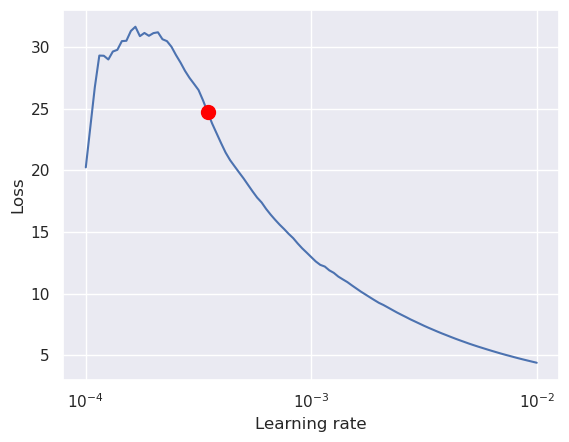

In [9]:
model = FirstFC()

trainer = pl.Trainer()

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, train_dl, val_dl, 
                                  min_lr=1e-4, max_lr=1e-2)

fig = lr_finder.plot(suggest=True)
fig.show()

In [11]:
print(f"LR suggested is: {lr_finder.suggestion()}")

LR suggested is: 0.0003467368504525317
